In [1]:
path_to_directory = "C:/Users/tiago/Desktop/DS/data_science_project"

file_tag = "class_ny_arrests"

train_filename = f"{path_to_directory}/datasets/{file_tag}_smote.csv"
test_filename = f"{path_to_directory}/datasets/{file_tag}_test_redundant.csv"

# **Classification**
## **Evaluation**
### Training Strategies
#### train_test_split function

In [2]:
from numpy import array, ndarray
from pandas import read_csv, DataFrame

target = "JURISDICTION_CODE"
data_train: DataFrame = read_csv(train_filename)
data_test: DataFrame = read_csv(test_filename)

#create a sample so it takes less time, change to the whole if needed in the future
data_train = data_train.sample(n=16000, random_state=42)
data_test = data_test.sample(n=4000, random_state=42)

labels: list = list(data_train[target].unique())
labels.sort()
print(f"Labels={labels}")
print(data_train.shape)
print(data_test.shape)

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {
    "Original": [
        len(data_train[data_train[target] == negative])+len(data_test[data_test[target] == negative]),
        len(data_train[data_train[target] == positive])+len(data_test[data_test[target] == positive]),
    ]
}

y_trn: array = data_train.pop(target).to_list()
X_trn: ndarray = data_train.values

y_tst: array = data_test.pop(target).to_list()
X_tst: ndarray = data_test.values


Labels=[0, 1]
(16000, 15)
(4000, 15)


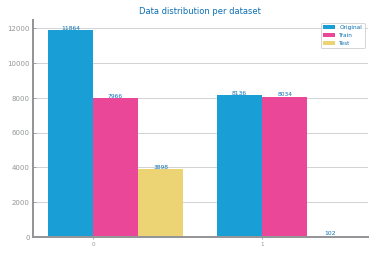

In [3]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart

#trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
trnX = X_trn
trnY = y_trn
tstX = X_tst
tstY = y_tst

train: DataFrame = concat(
    [DataFrame(trnX, columns=data_train.columns), DataFrame(trnY, columns=[target])], axis=1
)
train.to_csv(f"{path_to_directory}/datasets/{file_tag}_modeling_train.csv", index=False)

test: DataFrame = concat(
    [DataFrame(tstX, columns=data_test.columns), DataFrame(tstY, columns=[target])], axis=1
)
test.to_csv(f"{path_to_directory}/datasets/{file_tag}_modeling_test.csv", index=False)

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

#### Reading Train and Test datasets

In [4]:
from pandas import read_csv


def read_train_test_from_files(
    train_fn: str, test_fn: str, target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    train: DataFrame = read_csv(train_fn, index_col=None)
    labels: list = list(train[target].unique())
    labels.sort()
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    test: DataFrame = read_csv(test_fn, index_col=None)
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values
    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()


train_filename = f"{path_to_directory}/datasets/{file_tag}_modeling_train.csv"
test_filename = f"{path_to_directory}/datasets/{file_tag}_modeling_test.csv"
eval_metric = "accuracy"

trnX: ndarray
tstX: ndarray
trnY: array
tstY: array
labels: list
vars: list
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=16000 Test#=4000
Labels=[0, 1]


### Estimators and Models

In [5]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(trnX, trnY)
pred_trnY: array = clf.predict(trnX)
print(f"Score over Train: {clf.score(trnX, trnY):.3f}")
print(f"Score over Test: {clf.score(tstX, tstY):.3f}")

Score over Train: 0.613
Score over Test: 0.560


### Evaluation
#### Accuracy, Recall and Precision

In [6]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

pred_tstY: array = clf.predict(tstX)

acc: float = accuracy_score(tstY, pred_tstY)
recall: float = recall_score(tstY, pred_tstY)
prec: float = precision_score(tstY, pred_tstY)
print(f"accuracy={acc:.3f} recall={recall:.3f} precision={prec:.3f}")

accuracy=0.560 recall=0.706 precision=0.040


#### Confusion Matrix

In [7]:
from pandas import unique
from sklearn.metrics import confusion_matrix

labels: list = list(unique(tstY))
labels.sort()

prdY: array = clf.predict(tstX)
cnf_mtx_tst: ndarray = confusion_matrix(tstY, prdY, labels=labels)
print(cnf_mtx_tst)

[[2168 1730]
 [  30   72]]


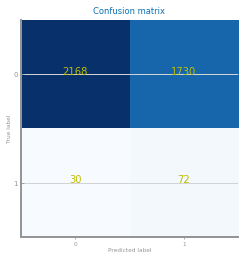

In [8]:
from itertools import product
from numpy import ndarray, set_printoptions, arange
from matplotlib.pyplot import gca, cm
from matplotlib.axes import Axes

def plot_confusion_matrix(cnf_matrix: ndarray, classes_names: ndarray, ax: Axes = None) -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    title = "Confusion matrix"
    set_printoptions(precision=2)
    tick_marks: ndarray = arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cnf_matrix, interpolation="nearest", cmap=cm.Blues)

    for i, j in product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.text(
            j, i, format(cnf_matrix[i, j], "d"), color="y", horizontalalignment="center"
        )
    return ax

figure()
plot_confusion_matrix(cnf_mtx_tst, labels)
show()

#### ROC Charts

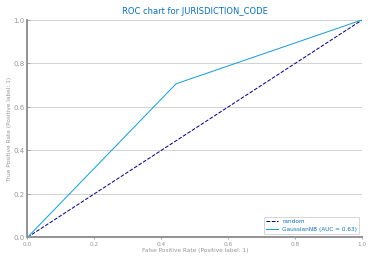

In [9]:
from sklearn.metrics import RocCurveDisplay
from config import ACTIVE_COLORS


def plot_roc_chart(tstY: ndarray, predictions: dict, ax: Axes = None, target: str = "class") -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.set_title("ROC chart for %s" % target)

    ax.plot(
        [0, 1],
        [0, 1],
        color="navy",
        label="random",
        linewidth=1,
        linestyle="--",
        marker="",
    )
    models = list(predictions.keys())
    for i in range(len(models)):
        RocCurveDisplay.from_predictions(
            y_true=tstY,
            y_pred=predictions[models[i]],
            name=models[i],
            ax=ax,
            color=ACTIVE_COLORS[i],
            linewidth=1,
        )
    ax.legend(loc="lower right", fontsize="xx-small")
    return ax


figure()
plot_roc_chart(tstY, {"GaussianNB": prdY}, target=target)
show()

<Figure size 432x288 with 0 Axes>

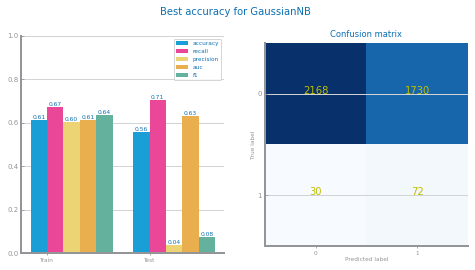

In [10]:
from typing import Callable
from matplotlib.figure import Figure
from matplotlib.pyplot import subplots, savefig, figure
from sklearn.metrics import roc_auc_score, f1_score
from dslabs_functions import plot_multibar_chart, HEIGHT

CLASS_EVAL_METRICS: dict[str, Callable] = {
    "accuracy": accuracy_score,
    "recall": recall_score,
    "precision": precision_score,
    "auc": roc_auc_score,
    "f1": f1_score,
}

def plot_evaluation_results(
    model, trn_y, prd_trn, tst_y, prd_tst, labels: ndarray
) -> ndarray:
    evaluation: dict = {}
    for key in CLASS_EVAL_METRICS:
        evaluation[key] = [
            CLASS_EVAL_METRICS[key](trn_y, prd_trn),
            CLASS_EVAL_METRICS[key](tst_y, prd_tst),
        ]

    params_st: str = "" if () == model["params"] else str(model["params"])
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    fig.suptitle(f'Best {model["metric"]} for {model["name"]} {params_st}')
    plot_multibar_chart(["Train", "Test"], evaluation, ax=axs[0], percentage=True)

    cnf_mtx_tst: ndarray = confusion_matrix(tst_y, prd_tst, labels=labels)
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])
    return axs

model_description: dict = {"name": "GaussianNB", "metric": eval_metric, "params": ()}

prd_trn: array = clf.predict(trnX)
prd_tst: array = clf.predict(tstX)
figure()
plot_evaluation_results(model_description, trnY, prd_trn, tstY, prd_tst, labels)
savefig(
    f'{path_to_directory}/images/{model_description["name"]}_best_{model_description["metric"]}_eval2.png', bbox_inches='tight'
)

show()

## **Naive Bayes**
### Study Naive Bayes Alternatives

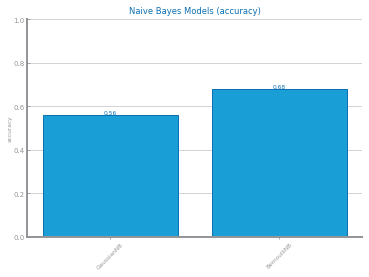

In [11]:
from numpy import array, ndarray
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart


def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        # print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params


figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
savefig(f"{path_to_directory}/images/Set 1 - NB {eval_metric} study2.png", bbox_inches='tight')
show()

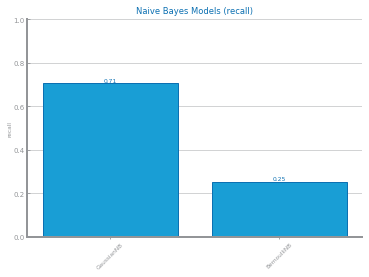

In [12]:
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, "recall")
savefig(f"{path_to_directory}/images/Set 1 - NB recall study2.png", bbox_inches='tight')
show()

### Performance Analysis

<Figure size 432x288 with 0 Axes>

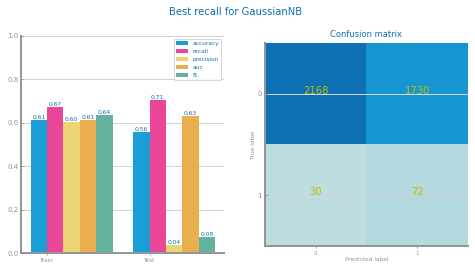

In [13]:
def plot_evaluation_results(model, trn_y, prd_trn, tst_y, prd_tst, labels: ndarray) -> ndarray:
    evaluation: dict = {}
    for key in CLASS_EVAL_METRICS:
        evaluation[key] = [
            CLASS_EVAL_METRICS[key](trn_y, prd_trn),
            CLASS_EVAL_METRICS[key](tst_y, prd_tst),
        ]

    params_st: str = "" if () == model["params"] else str(model["params"])
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    fig.suptitle(f'Best {model["metric"]} for {model["name"]} {params_st}')
    plot_multibar_chart(["Train", "Test"], evaluation, ax=axs[0], percentage=True)

    cnf_mtx_tst: ndarray = confusion_matrix(tst_y, prd_tst, labels=labels)
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])

    # Return the axes and the test evaluation metrics only
    test_evaluation = {key: evaluation[key][1] for key in evaluation}
    return axs, test_evaluation


prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
_, test_evaluation = plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
evaluation_results = {"NB": test_evaluation}

savefig(f'{path_to_directory}/images/Set 1 - NB {params["name"]} best {params["metric"]} eval2.png', bbox_inches='tight')
show()

### Overfitting
Overfitting study is not usual in Naive Bayes models.

## **KNN**
### Paremeters study

Train#=16000 Test#=4000
Labels=[0, 1]
KNN best with k=1 and manhattan


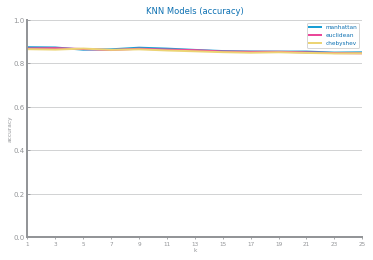

In [14]:
from typing import Literal, Union
from numpy import array, ndarray
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multiline_chart
from dslabs_functions import read_train_test_from_files

def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[Union[KNeighborsClassifier, None], dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            # print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f"KNN best with k={best_params['params'][0]} and {best_params['params'][1]}")
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
savefig(f'{path_to_directory}/images/Set 1 - KNN {eval_metric} study2.png', bbox_inches='tight')
show()

### Best model performance

<Figure size 432x288 with 0 Axes>

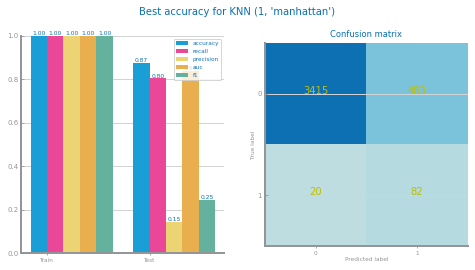

In [15]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 1 - KNN {params["name"]} best {params["metric"]} eval2.png', bbox_inches='tight')
show()

### Overfitting study

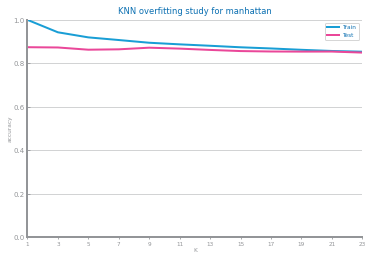

In [16]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - KNN overfitting2.png", bbox_inches='tight')
show()

In this case, we don't see any overfitting, since the performance on both train and test sets keep the same trend.

## **Decision Trees**
### Paremeters study

Train#=16000 Test#=4000
Labels=[0, 1]
DT best with gini and d=10


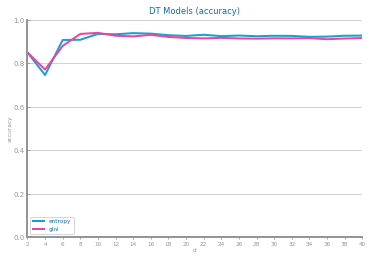

In [17]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.tree import DecisionTreeClassifier
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from dslabs_functions import plot_multiline_chart


def trees_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=10, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0, random_state=42)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f"DT best with {best_params['params'][0]} and d={best_params['params'][1]}")
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params

eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=40, metric=eval_metric)
savefig(f'{path_to_directory}/images/Set 1 - DT {eval_metric} study2.png', bbox_inches='tight')
show()

### Best model performance

<Figure size 432x288 with 0 Axes>

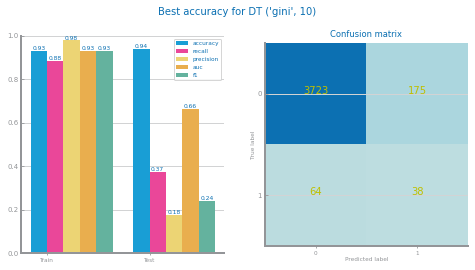

In [18]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
_, test_evaluation = plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
evaluation_results["DT"] = test_evaluation

savefig(f'{path_to_directory}/images/Set 1 - DT {params["name"]} best {params["metric"]} eval2.png', bbox_inches='tight')
show()

### Variables importance

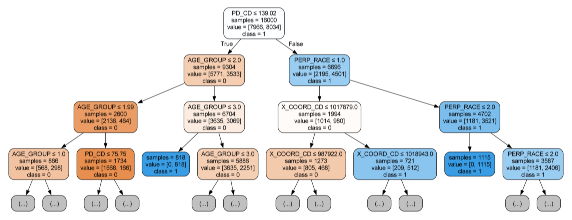

In [19]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"{path_to_directory}/images/Set 1 - DT {eval_metric} best tree 2"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(10,4))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

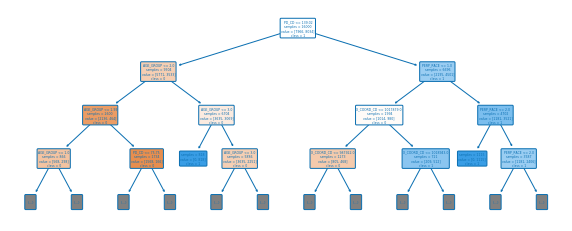

In [20]:
from sklearn.tree import plot_tree

figure(figsize=(10,4))
plot_tree(
    best_model,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + ".png", bbox_inches='tight')

1. AGE_GROUP (0.35565153712387826)
2. PERP_RACE (0.17832996864730238)
3. PD_CD (0.1360654054516827)
4. X_COORD_CD (0.09796516836979319)
5. ARREST_PRECINCT (0.0590335309625128)
6. OFNS_DESC (0.04937496169181593)
7. Y_COORD_CD (0.04836490564722925)
8. KY_CD (0.021217611112725396)
9. Month_cos (0.014231716993654789)
10. Month_sin (0.013101669104885931)
11. Year (0.011198399504212532)
12. PERP_SEX (0.010040133276560627)
13. Day (0.004587086979120696)
14. ARREST_BORO (0.0008379051346255169)


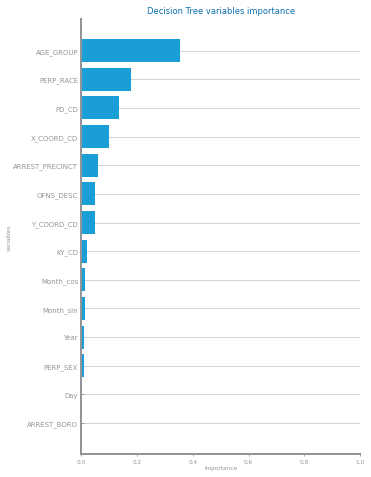

In [21]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure(figsize=(5, 8))
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - DT {eval_metric} vars ranking2.png", bbox_inches='tight')

### Overfitting study

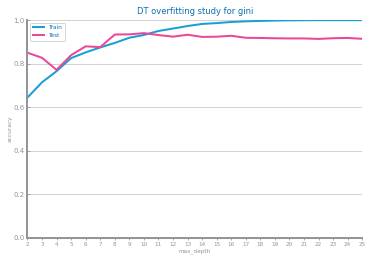

In [22]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0, random_state=42)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - DT {eval_metric} overfitting2.png", bbox_inches='tight')

In this case, it seems to have some overfitting since the training is always progressing while the test goes up and down at the beggining.

## **Neural Networks**
### Multi Layer Perceptrons
#### Parameters study

Train#=16000 Test#=4000
Labels=[0, 1]
MLP best for 1000 iterations (lr_type=constant and lr=0.5


<Figure size 432x288 with 0 Axes>

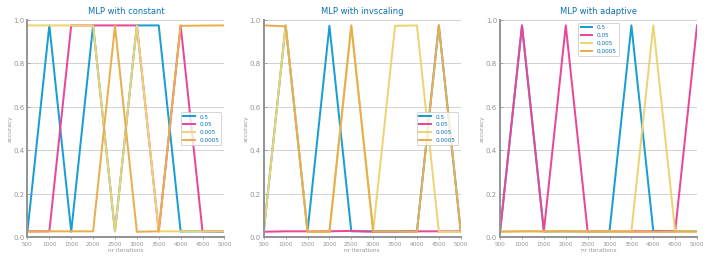

In [23]:
from typing import Literal, Union
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.neural_network import MLPClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_multiline_chart

LAG: int = 500
NR_MAX_ITER: int = 5000

def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[Union[MLPClassifier, None], dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False, random_state=42
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f"MLP best for {best_params['params'][2]} iterations (lr_type={best_params['params'][0]} and lr={best_params['params'][1]}"
    )

    return best_model, best_params

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=NR_MAX_ITER,
    lag=LAG,
    metric=eval_metric,
)
savefig(f"{path_to_directory}/images/Set 1 - MLP {eval_metric} study2.png", bbox_inches='tight')
show()

#### Best model performance

<Figure size 432x288 with 0 Axes>

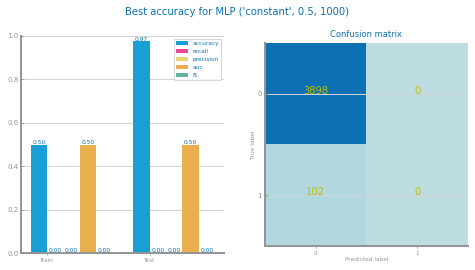

In [24]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
_, test_evaluation = plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
evaluation_results["MLP"] = test_evaluation

savefig(f'{path_to_directory}/images/Set 1 - MLP {params["name"]} best {params["metric"]} eval2.png', bbox_inches='tight')
show()

#### Overfitting study


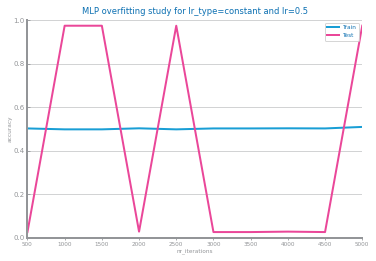

In [25]:
lr_type: Literal["constant", "invscaling", "adaptive"] = params["params"][0]
lr: float = params["params"][1]

nr_iterations: list[int] = [LAG] + [i for i in range(2 * LAG, NR_MAX_ITER + 1, LAG)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False, random_state=42
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - MLP {eval_metric} overfitting2.png", bbox_inches='tight')

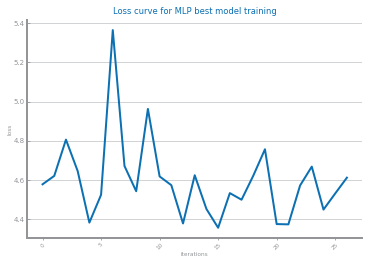

In [26]:
from numpy import arange
from dslabs_functions import plot_line_chart


figure()
plot_line_chart(
    arange(len(best_model.loss_curve_)),
    best_model.loss_curve_,
    title="Loss curve for MLP best model training",
    xlabel="iterations",
    ylabel="loss",
    percentage=False,
)
savefig(f"{path_to_directory}/images/Set 1 - MLP {eval_metric} loss curve.png")

## **Random Forests**
### Parameters study

Train#=16000 Test#=4000
Labels=[0, 1]
RF best for 500 trees (d=7 and f=0.7)


<Figure size 432x288 with 0 Axes>

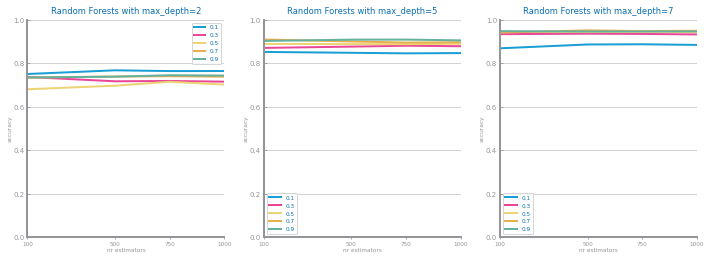

In [27]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import RandomForestClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_multiline_chart


def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[Union[RandomForestClassifier, None], dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f, random_state=42
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f"RF best for {best_params['params'][2]} trees (d={best_params['params'][0]} and f={best_params['params'][1]})"
    )
    return best_model, best_params


trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"{path_to_directory}/images/Set 1 - RF {eval_metric} study2.png", bbox_inches='tight')
show()

<Figure size 432x288 with 0 Axes>

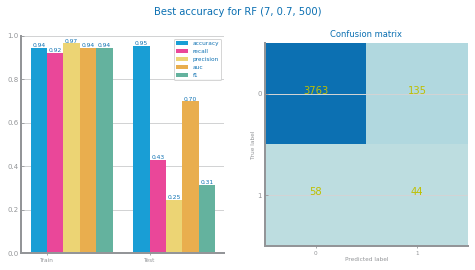

In [28]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
_, test_evaluation = plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
evaluation_results["RF"] = test_evaluation

savefig(f'{path_to_directory}/images/Set 1 - RF {params["name"]} best {params["metric"]} eval2.png', bbox_inches='tight')
show()

1. AGE_GROUP (0.31950522463809095)
2. PERP_RACE (0.1389413679763603)
3. PD_CD (0.11852425273712162)
4. ARREST_PRECINCT (0.08011583192197176)
5. OFNS_DESC (0.07776189668147605)
6. Month_sin (0.07007034194362137)
7. Month_cos (0.05973757504261217)
8. X_COORD_CD (0.04881700397289199)
9. Y_COORD_CD (0.03647254503075914)
10. KY_CD (0.020357459240080162)
11. PERP_SEX (0.01443048562676178)
12. ARREST_BORO (0.008103545761492326)
13. Year (0.005432977809832893)
14. Day (0.0017294916169274953)


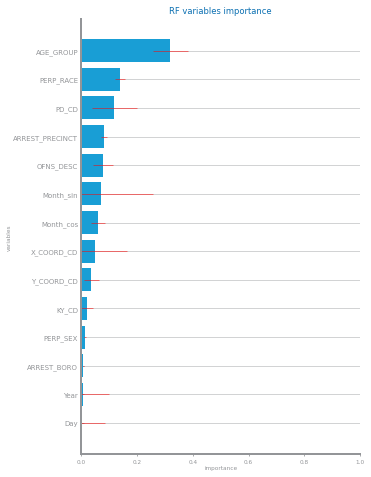

In [29]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure(figsize=(5, 8))
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - RF {eval_metric} vars ranking2.png", bbox_inches='tight')

### Overfitting study


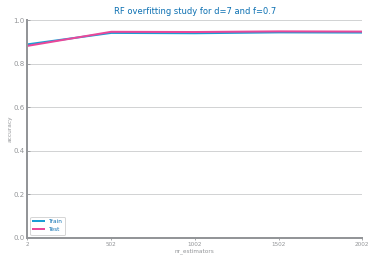

In [30]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat, random_state=42)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - RF {eval_metric} overfitting2.png", bbox_inches='tight')

There is no overfitting, since the accuracy over both datasets almost does not change.

## **Gradient Boosting**
### Paremeters study

Train#=16000 Test#=4000
Labels=[0, 1]
GB best for 1000 trees (d=5 and lr=0.3


<Figure size 432x288 with 0 Axes>

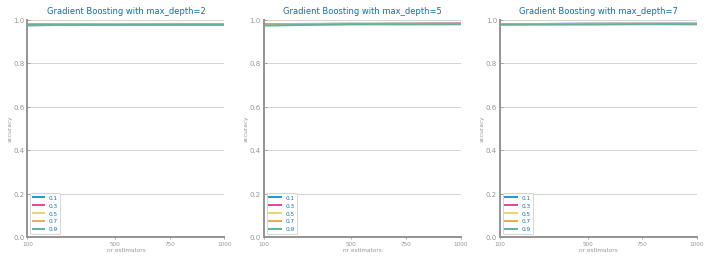

In [31]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import GradientBoostingClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_multiline_chart


def gradient_boosting_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[Union[GradientBoostingClassifier, None], dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    learning_rates: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: GradientBoostingClassifier | None = None
    best_params: dict = {"name": "GB", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for lr in learning_rates:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = GradientBoostingClassifier(
                    n_estimators=n, max_depth=d, learning_rate=lr, random_state=42
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, lr, n)
                    best_model = clf
            values[lr] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Gradient Boosting with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f"GB best for {best_params['params'][2]} trees (d={best_params['params'][0]} and lr={best_params['params'][1]}"
    )

    return best_model, best_params

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"{path_to_directory}/images/Set 1 - GB {eval_metric} study2.png", bbox_inches='tight')
show()

### Best model performance


<Figure size 432x288 with 0 Axes>

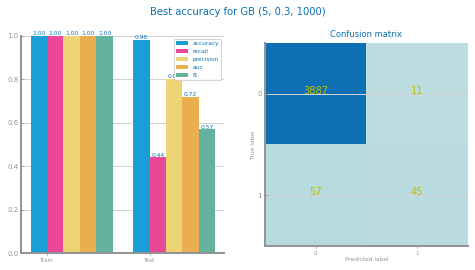

In [32]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
_, test_evaluation = plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
evaluation_results["GB"] = test_evaluation

savefig(f'{path_to_directory}/images/Set 1 - GB {params["name"]} best {params["metric"]} eval2.png', bbox_inches='tight')
show()

### Variables importance

1. AGE_GROUP (0.30231329838290616)
2. Month_sin (0.20687289004005632)
3. Month_cos (0.1603633459488496)
4. PERP_RACE (0.08148824087384378)
5. PD_CD (0.06297880685838574)
6. ARREST_PRECINCT (0.054377047383109015)
7. X_COORD_CD (0.041045450597651405)
8. OFNS_DESC (0.032834255412832504)
9. PERP_SEX (0.026251954095503276)
10. Y_COORD_CD (0.01637995724206496)
11. KY_CD (0.005984048056797448)
12. Year (0.0047265971739420135)
13. Day (0.004008550961271961)
14. ARREST_BORO (0.0003755569727856837)


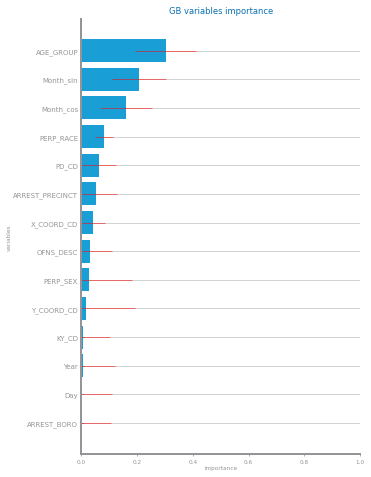

In [33]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure(figsize=(5, 8))
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - GB {eval_metric} vars ranking2.png", bbox_inches='tight')

### Overfitting study


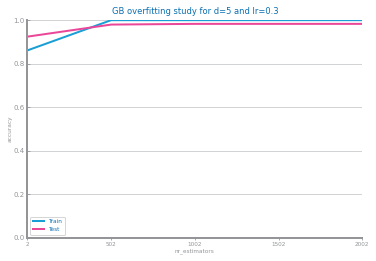

In [34]:
d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr, random_state=42)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - GB {eval_metric} overfitting2.png", bbox_inches='tight')

## **FINAL EVALUATION**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

FONT_SIZE = 6
FONT_TEXT = FontProperties(size=FONT_SIZE)

# Extracting metric names and values for each model
metrics = list(next(iter(evaluation_results.values())).keys())
models = list(evaluation_results.keys())

# Preparing data for the bar plots
values = {metric: [evaluation_results[model][metric] for model in models] for metric in metrics}
colors = plt.cm.tab10(np.arange(len(models)))

# Creating subplots (3 on top, 2 at the bottom)
fig, axs = plt.subplots(2, 3, figsize=(8, 5))
axs = axs.ravel()  # Flatten the axes array

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axs[i]
    bars = ax.bar(models, values[metric], color=colors, alpha=1)
    ax.set_title(metric.capitalize(), fontproperties=FONT_TEXT)
    ax.set_ylim(0, 1)  # Assuming metric values are between 0 and 1
    ax.set_ylabel("Value", fontproperties=FONT_TEXT)
    ax.set_xlabel("Model", fontproperties=FONT_TEXT)
    
    # Add text on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height, 
            f'{height:.2f}', 
            ha='center', 
            va='bottom', 
            fontproperties=FONT_TEXT
        )

# Hide any extra subplots if present
for i in range(len(metrics), len(axs)):
    axs[i].axis('off')

# Adjust layout
fig.tight_layout()
plt.savefig(f"{path_to_directory}/images/Set 1 - Models’ evaluation per metric.png", bbox_inches='tight')
plt.show()

# Calculate and print the average of each model's metric scores
for model in models:
    model_metrics = evaluation_results[model]
    average_score = np.mean([score for score in model_metrics.values()])
    print(f'Average score for {model}: {average_score:.3f}')